# Plotting leading shower energy against angle

A simple notebook to look at some kinematics of the signal sample.





Pickle column names:

run_ls	sub_ls	evt_ls	shr_energy_tot_ls	pfnplanehits_Y_ls	contained_fraction_ls	shr_pitch_u_v_ls	trk_energy_ls	contained_sps_ratio_ls	total_hits_y_ls	trk_energy_hits_tot_ls	shr_start_x_ls	nu_pdg_ls	ccnc_ls	nu_parent_pdg_ls	theta_ls	reco_nu_vtx_sce_x_ls	reco_nu_vtx_sce_y_ls	reco_nu_vtx_sce_z_ls	npi0_ls	crtveto_ls	slpdg_ls	trk_score_v_ls	topological_score_ls	ppfx_cv_ls	n_showers_contained_MCStool_ls	DeltaMed_ls	NeutrinoEnergy2_ls	shr_energy_y_v_ls	shr_pfp_id_v_ls	hits_v_ls	n_tracks_ls	pi0_dir1_x_ls	pi0_dir1_z_ls	pi0_energy1_Y_ls	pi0_mass_Y_ls	shrclusdir0_ls	shrclusdir1_ls	shrclusdir2_ls	shr_openangle_ls	shr_theta_ls	shr_pca_0_ls	shr_px_ls	shr_px_v_ls	shr_pz_ls	trk_len_v_ls	pfnhits_ls	nslice_ls	shr_py_v_ls	shr_pz_v_ls	shr_start_x_v_ls	shr_start_y_v_ls	shr_start_z_v_ls	shr_dedx_y_v_ls	nu_e_ls	true_nu_pz_ls	temp_ID	test_sample_POT_ls	test_scale_POT_ls	run_mc_ls	sub_mc_ls	evt_mc_ls	mc_primary_px_ls	mc_primary_py_ls	mc_primary_pz_ls	mc_primary_pdg_ls	Counts_ls	dist_bw_koto_shower_x_ls	dist_bw_koto_shower_y_ls	dist_bw_koto_shower_z_ls	dist_bw_koto_shower_ls	shr_energy_y_v_corrected_ls	bnb_scale_ls	KDAR_scale	pred	is_trained	run	sub	evt	weightsPPFX	frac_test_sample	scale_factor_ls	logit_pred

In [1]:
import os,sys,uproot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from scipy.special import logit
import uproot
import ROOT
from array import array
from math import floor, log10
import decay_widths as dw
import collections

import Create_collie_inputs_slimmed as Aditya_funcs

print ('Success')
### Some root paths used by different users/devices
#     root_dir = "../../For_David/" for the default root directory used by David
#     root_dir = "/exp/uboone/data/users/jbateman/workdir/HPS_uboone_analysis/" # Filepath used on the FNAL cluster.
#     root_dir = "/Users/user/PhD/HPS_uboone_analysis/" # A filepath used for local running.

root_dir = "/Users/user/PhD/HPS_uboone_analysis/"

In [43]:
def Get_ratios_trained(df):
    """
    Given a dataframe with variable \"is_trained\", will print the numbers of events with zero, number of events where it is one and the fraction of zeros.
    """
    num_zeros = len(df.query('is_trained==0'))
    num_ones = len(df.query('is_trained==1'))
    print(f"Zeros: {num_zeros}")
    print(f"Ones: {num_ones}")
    print(f"Fraction of zeros: {num_zeros/(num_zeros+num_ones)}")
    
def sci_notation(num, decimal_digits=0, precision=None, exponent=None):
    """
    Returns a string representation of the scientific
    notation of the given number formatted for use with
    LaTeX or Mathtext, with specified number of significant
    decimal digits and precision (number of decimal digits
    to show). The exponent to be used can also be specified
    explicitly.
    """
    if exponent is None:
        exponent = int(floor(log10(abs(num))))
    coeff = round(num / float(10**exponent), decimal_digits)
    if precision is None:
        precision = decimal_digits

    return r"${0:.{1}f}\times10^{{{{".format(coeff,precision)+"{0:d}".format(exponent)+"}}$"

def match_RSE_indices(pkl_data, uproot_file,columns=[0,1,2]):
    """
    This function matches events in the pkl file to the uproot file, using the run, subrun and event number.
    It returns the indices of the uproot file that match the pkl file, used to retrive the time of 
    flight values. 
    """
    
    test_run = pkl_data['run_ls'].to_numpy()
    test_subrun = pkl_data['sub_ls'].to_numpy()
    test_event = pkl_data['evt_ls'].to_numpy()

    keys = uproot_file.keys()
    data = uproot_file[keys[0]]
    keys = data.keys()
    runs = data[keys[columns[0]]].array()
    subruns = data[keys[columns[1]]].array()
    event = data[keys[columns[2]]].array()

    indices = []
    for i, run in enumerate(test_run):
        run_args = np.where(runs==run)
        subrun_args = np.where(subruns==test_subrun[i])
        event_arg = np.where(event==test_event[i])
        shared_run_sub_arg = np.intersect1d(run_args, subrun_args)
        shared_arg = np.intersect1d(shared_run_sub_arg, event_arg)
        indices.append(shared_arg[0])
    return indices

def New_loader(Run, mass, nshr, KDIF_KDAR_str, bool_full_sample=True, get_tof=False, for_david=True):
    """
    New function to load the .pkl files as dataframes. Mostly taken directly from Aditya's code.
    get_tof is a boolean that determines whether to load the time of flight values from the root file.
    """
    #Constants for normalisation factors
    
    mc_pot_fhc = 2.33652e+21
    mc_pot_rhc = 1.98937e+21
    dirt_pot_fhc = 1.42143e+21
    dirt_pot_rhc = 1.03226e+21
    OnBeam_EA9CNT_wcut_fhc = 5268051.0
    OnBeam_EA9CNT_wcut_rhc = 10363728.0
    OffBeam_EXT_NUMIwin_FEMBeamTriggerAlgo_fhc = 9199232.74
    OffBeam_EXT_NUMIwin_FEMBeamTriggerAlgo_rhc = 32878305.25
    scale_ext_fhc = OnBeam_EA9CNT_wcut_fhc/OffBeam_EXT_NUMIwin_FEMBeamTriggerAlgo_fhc
    scale_ext_rhc = OnBeam_EA9CNT_wcut_rhc/OffBeam_EXT_NUMIwin_FEMBeamTriggerAlgo_rhc
    scale_ext_fhc = scale_ext_fhc*.98
    scale_ext_rhc = scale_ext_rhc*.98
    OnBeam_tortgt_wcut_fhc = 2.002e20
    OnBeam_tortgt_wcut_rhc = 5.009e20
    scale_nu_fhc = OnBeam_tortgt_wcut_fhc/mc_pot_fhc
    scale_nu_rhc = OnBeam_tortgt_wcut_rhc/mc_pot_rhc
    scale_dirt_fhc = OnBeam_tortgt_wcut_fhc/dirt_pot_fhc
    scale_dirt_rhc = OnBeam_tortgt_wcut_rhc/dirt_pot_rhc
    scale_dirt_fhc = scale_dirt_fhc*0.75
    scale_dirt_rhc = scale_dirt_rhc*0.35
    
    if Run == 'Run1':
        fhc_rhc_str = 'fhc'
        OnBeam_tortgt_wcut = OnBeam_tortgt_wcut_fhc
        scale_nu = scale_nu_fhc
        scale_dirt = scale_dirt_fhc
        scale_ext = scale_ext_fhc
    elif Run == 'Run3':
        fhc_rhc_str = 'rhc'
        OnBeam_tortgt_wcut = OnBeam_tortgt_wcut_rhc
        scale_nu = scale_nu_rhc
        scale_dirt = scale_dirt_rhc
        scale_ext = scale_ext_rhc
    
    main_input_dir = ROOT_DIR+"/BDT_inputs_pkl/"
    
    ### DATA ###
    if bool_full_sample == True:
        print ('No data')
        df_data = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_opendata_'+nshr+'_NEW.pkl')
        df_data ['pred'] = 1.0
    else:
        df_data = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Opendata_'+KDIF_KDAR_str+'_'+mass+'_'+nshr+'_PPFX_pred_NEW.pkl')
    
    #### SIG ####
    if bool_full_sample == True: print ('No signal')
    else:
        df_sig = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Signal_'+KDIF_KDAR_str+'_'+mass+'_'+nshr+'_PPFX_pred_NEW.pkl')
        if get_tof==True:
            tof_file = f"tof_{fhc_rhc_str}_{mass}.root"

            with uproot.open("TOF_input_root/"+tof_file) as tof_data:
                indices = match_RSE_indices(df_sig, tof_data)
                keys = tof_data.keys()
                tof_data = tof_data[keys[0]]
                tof = tof_data['proper_tof'].array()[indices].to_numpy()

            df_sig['tof'] = tof
        frac_sig_test_sample = len(df_sig.query('is_trained == 0'))/len(df_sig)
        df_sig['frac_test_sample'] = frac_sig_test_sample #Should be 0.4
        df_sig = df_sig.query('is_trained==0') #Only taking testing events!
        df_sig.eval('scale_factor_ls = (1/frac_test_sample)*KDAR_scale*'+str(OnBeam_tortgt_wcut)+'/test_sample_POT_ls',inplace=True)

    #### OVL ####
    if bool_full_sample == True:
        df_ovl = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Overlay_'+nshr+'_WEIGHTS_NEW.pkl')
        df_ovl.eval('scale_factor_ls = KDAR_scale*'+str(scale_nu),inplace=True)
        df_ovl ['pred'] = 1.0
    else:
        df_ovl = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Overlay_'+KDIF_KDAR_str+'_'+mass+'_'+nshr+'_PPFX_pred_NEW.pkl')
        frac_ovl_test_sample = len(df_ovl.query('is_trained == 0'))/len(df_ovl) #Should be 0.4
        df_ovl['frac_test_sample'] = frac_ovl_test_sample
        df_ovl = df_ovl.query('is_trained==0')
        df_ovl.eval('scale_factor_ls = (1/frac_test_sample)*KDAR_scale*'+str(scale_nu),inplace=True)
    
    df_ovl['is_good_genie'] = 1
    df_ovl['is_good_ppfx'] = 1
    df_ovl['is_good_reint'] = 1
    
    df_ovl['thsnd_weight_genie'] = (['yes' if all(a == 1000 for a in i) else 'no' for i in df_ovl['weightsGenie']])
    df_ovl['thsnd_weight_ppfx'] = (['yes' if all(a == 1000 for a in i) else 'no' for i in df_ovl['weightsPPFX']])
    df_ovl['thsnd_weight_reint'] = (['yes' if all(a == 1000 for a in i) else 'no' for i in df_ovl['weightsReint']])
    
    df_ovl.loc[df_ovl['inf_weight_genie'] == "yes", 'is_good_genie'] = 0
    df_ovl.loc[df_ovl['zero_weight_genie'] == "yes", 'is_good_genie'] = 0
    df_ovl.loc[df_ovl['ones_weight_genie'] == "yes", 'is_good_genie'] = 0
    df_ovl.loc[df_ovl['thsnd_weight_genie'] == "yes", 'is_good_genie'] = 0
    
    df_ovl.loc[df_ovl['inf_weight_ppfx'] == "yes", 'is_good_ppfx'] = 0
    df_ovl.loc[df_ovl['zero_weight_ppfx'] == "yes", 'is_good_ppfx'] = 0
    df_ovl.loc[df_ovl['ones_weight_ppfx'] == "yes", 'is_good_ppfx'] = 0
    df_ovl.loc[df_ovl['thsnd_weight_ppfx'] == "yes", 'is_good_ppfx'] = 0
    
    df_ovl.loc[df_ovl['inf_weight_reint'] == "yes", 'is_good_reint'] = 0
    df_ovl.loc[df_ovl['zero_weight_reint'] == "yes", 'is_good_reint'] = 0
    df_ovl.loc[df_ovl['ones_weight_reint'] == "yes", 'is_good_reint'] = 0
    df_ovl.loc[df_ovl['thsnd_weight_reint'] == "yes", 'is_good_reint'] = 0

    ### DIRT ###
    if bool_full_sample == True:
        df_dirt = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Dirt_'+nshr+'_WEIGHTS_NEW.pkl')
        df_dirt.eval('scale_factor_ls = KDAR_scale*'+str(scale_dirt),inplace=True)
        df_dirt ['pred'] = 1.0
    else:
        df_dirt = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Dirt_'+KDIF_KDAR_str+'_'+mass+'_'+nshr+'_PPFX_pred_NEW.pkl')
        frac_dirt_test_sample = len(df_dirt.query('is_trained == 0'))/len(df_dirt)
        df_dirt['frac_test_sample'] = frac_dirt_test_sample

        df_dirt = df_dirt.query('is_trained==0')
        df_dirt.eval('scale_factor_ls = (1/frac_test_sample)*KDAR_scale*'+str(scale_dirt),inplace=True)
    
    df_dirt['is_good'] = 0
    
    #### EXT ####
    if bool_full_sample == True:
        df_ext = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Ext_'+nshr+'_WEIGHTS_NEW.pkl')
        df_ext.eval('scale_factor_ls = KDAR_scale*'+str(scale_ext),inplace=True)
        df_ext ['pred'] = 1.0
    else:
        df_ext = pd.read_pickle(main_input_dir+'AllVar_Selected_'+Run+'_NuMI_Ext_'+KDIF_KDAR_str+'_'+mass+'_'+nshr+'_PPFX_pred_NEW.pkl')
        frac_ext_test_sample = len(df_ext.query('is_trained == 0'))/len(df_ext)
        df_ext['frac_test_sample'] = frac_ext_test_sample

        df_ext = df_ext.query('is_trained==0')
        df_ext.eval('scale_factor_ls = (1/frac_test_sample)*KDAR_scale*'+str(scale_ext),inplace=True)
   
    #### Detsys ####
    if mass == '125' or mass == '130' or mass == '135' or mass == '140' or mass == '145':
        detsys_mass = '150'
        print("Loading 150 MeV detsys samples")
    else: detsys_mass = mass
    
    # detsys_sig_input_dir = './Final_detector_systematics_SIGNAL/'+detsys_mass+'_MeV/'
    # detsys_bkg_input_dir = './Final_detector_systematics_BACKGROUND/'+detsys_mass+'_MeV/'
    detsys_sig_input_dir = ROOT_DIR+'/Final_detector_systematics_SIGNAL/'+detsys_mass+'_MeV/'
    detsys_bkg_input_dir = ROOT_DIR+'/Final_detector_systematics_BACKGROUND/'+detsys_mass+'_MeV/'

    KDIF_KDAR_str_lower = KDIF_KDAR_str.lower()
    df_sig_detsys = pd.read_pickle(detsys_sig_input_dir + 'Signal_' + fhc_rhc_str + '_' + detsys_mass + '_MeV_' + nshr + '_' + KDIF_KDAR_str_lower +'.pkl')
    df_ovl_detsys = pd.read_pickle(detsys_bkg_input_dir + "bkg_" + fhc_rhc_str + '_' + detsys_mass + '_MeV_' + nshr + '_' + KDIF_KDAR_str_lower +'.pkl')
    
    if bool_full_sample == True: print ('NO LOGIT FOR SIGNAL..')
    else: df_sig['logit_pred'] = logit(df_sig['pred'])
    
    df_ovl['logit_pred'] = logit(df_ovl['pred'])
    df_dirt['logit_pred'] = logit(df_dirt['pred'])
    df_ext['logit_pred'] = logit(df_ext['pred'])
    df_data['logit_pred'] = logit(df_data['pred'])
    
    pred_column_sig = [col for col in df_sig_detsys if col.startswith('pred')]
    pred_column_ovl = [col for col in df_ovl_detsys if col.startswith('pred')]
    
    df_sig_detsys_copy = df_sig_detsys.copy()
    df_ovl_detsys_copy = df_ovl_detsys.copy()
    
    for pred in pred_column_sig:
        df_sig_detsys_copy['logit_'+pred] = logit(df_sig_detsys[pred])
    
    for pred in pred_column_ovl:
        df_ovl_detsys_copy['logit_'+pred] = logit(df_ovl_detsys[pred])

    print (f'SUCCESSFULLY LOADED THE PICKLE FILES {Run, mass, nshr, KDIF_KDAR_str}')
    
    if bool_full_sample == True:
        return df_ovl, df_dirt, df_ext, df_data, df_sig_detsys_copy, df_ovl_detsys_copy
    else:
        return df_sig, df_ovl, df_dirt, df_ext, df_data, df_sig_detsys_copy, df_ovl_detsys_copy
    

In [44]:
df_sig_dict, df_overlay_dict, df_dirt_dict, df_beamoff_dict, df_data_dict = {},{},{},{},{}
sig_detsys_dict, ov_detsys_dict = {}, {}
HNL_masses = [100] #, 125, 130, 135, 140, 145, 150, 200] #Full set of HPS mass points, ignore the fact is says HNL
# HNL_masses = [100] #Can use reduced set of mass points so the script runs quicker.

Run = "3"

runs = [Run]
get_TOF = False # Set to true to load time of flight values, used for the axion reweighting.
data_pkl = {}
for run in runs:
    for HNL_mass in HNL_masses:
        for shr in ["1shr", "2shr"]:
            for K in ["KDIF", "KDAR"]:
                name = f"{HNL_mass}_{shr}_{K}"
                df_sig_dict[name], df_overlay_dict[name], df_dirt_dict[name], df_beamoff_dict[name], df_data_dict[name], sig_detsys_dict[name], ov_detsys_dict[name] = New_loader('Run'+Run, str(HNL_mass), shr, K, bool_full_sample=False, get_tof=get_TOF, for_david=False)
                
                filepath =  ROOT_DIR+'BDT_inputs_pkl/AllVar_Selected_Run{}_NuMI_Signal_{}_{}_{}_PPFX_pred_NEW.pkl'.format(run,K,HNL_mass,shr)
                name = "Run{}_{}_{}_{}".format(Run,K,HNL_mass,shr)
                data_pkl[name] = pd.read_pickle(filepath)
print()
print("Loaded all!")

SUCCESSFULLY LOADED THE PICKLE FILES ('Run3', '100', '1shr', 'KDIF')
SUCCESSFULLY LOADED THE PICKLE FILES ('Run3', '100', '1shr', 'KDAR')
SUCCESSFULLY LOADED THE PICKLE FILES ('Run3', '100', '2shr', 'KDIF')
SUCCESSFULLY LOADED THE PICKLE FILES ('Run3', '100', '2shr', 'KDAR')

Loaded all!


In [44]:
def plot_2d_feature_hist(df_array, xaxis, yaxis, title = "", test_point='100_1shr_KDIF'):

    x = np.array([])
    y = np.array([])
    for df_temp in df_array:
        temp = df_temp[xaxis].to_numpy()
        x = np.append(x, temp)
        temp = df_temp[yaxis].to_numpy()
        y = np.append(y, temp)

    plt.hist2d(x, y, bins=(50,50), cmin=1, )
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.colorbar()
    if title != "":
        plt.title(title)
    plt.show()

    return x, y

In [45]:
print(np.shape(df_sig_dict['100_1shr_KDIF']), np.shape(df_sig_dict['100_1shr_KDAR']), np.shape(df_sig_dict['100_2shr_KDIF']),np.shape(df_sig_dict['100_2shr_KDAR']))


(5318, 83) (1109, 83) (2045, 167) (674, 167)


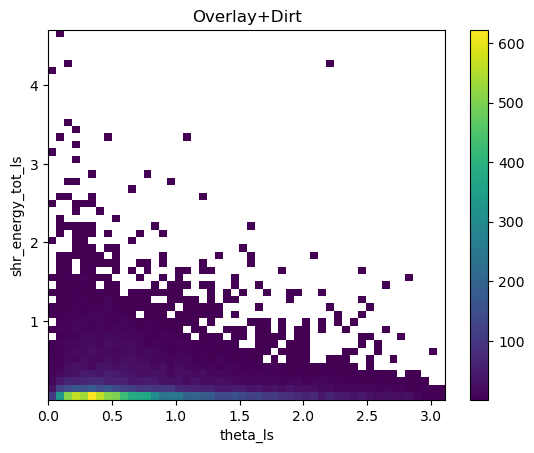

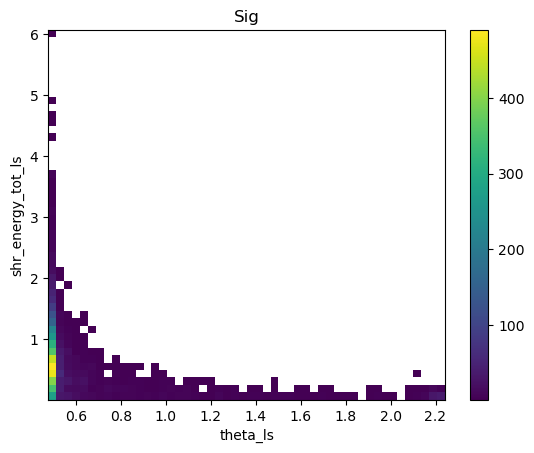

In [10]:

index_labels = ['theta_ls', 'shr_energy_tot_ls', 'shr_energy_y_v_corrected_ls', 'trk_energy_ls']
mass_point = '100_1shr_KDIF'
x_axis_label = 'shr_energy_y_v_corrected_ls'
y_axis_label = 'shr_energy_tot_ls'


dirt_over_x, dirt_over_y = plot_2d_feature_hist([df_overlay_dict[mass_point], df_dirt_dict[mass_point], ], x_axis_label, y_axis_label, title="Overlay+Dirt")
sig_x, sig_y = plot_2d_feature_hist([df_sig_dict[mass_point]], x_axis_label, y_axis_label, title="Sig")



/tmp/ipykernel_2497/4055926837.py:7: RuntimeWarning: divide by zero encountered in divide
  ratio_hist = sig_hist/dirt_over_hist
/tmp/ipykernel_2497/4055926837.py:7: RuntimeWarning: invalid value encountered in divide
  ratio_hist = sig_hist/dirt_over_hist


Text(0.5, 1.0, 'Signal / Dirt+Overlay')

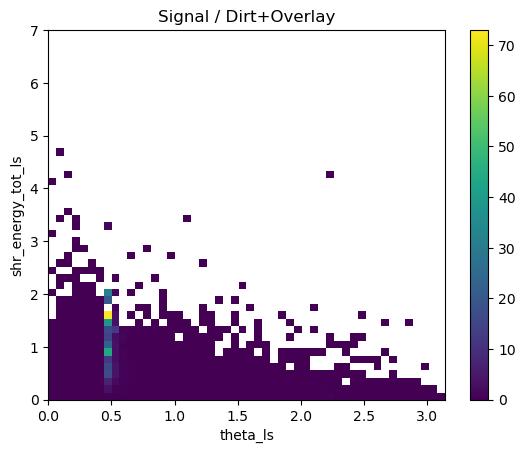

In [31]:

x_lim = [0,np.pi]
y_lim = [0,7]

sig_hist, xbins, ybins = np.histogram2d(sig_x, sig_y, bins=(50,50), range=[x_lim, y_lim])
dirt_over_hist, xbins, ybins = np.histogram2d(dirt_over_x, dirt_over_y, bins=(50,50), range=[x_lim, y_lim])

ratio_hist = sig_hist/dirt_over_hist
ratio_hist = ratio_hist.T

plt.imshow(ratio_hist, extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]], aspect='auto', origin='lower')
plt.colorbar()
plt.xlabel(x_axis_label)
plt.ylabel(y_axis_label)
plt.title(r"Signal / Dirt+Overlay")

## Importing root dataset & comparing kinematics

In [73]:
mass_points = np.asarray([100]) #,125,130,135,140,145,150,200]) # MeV
theta_values = np.asarray([5.36]) # ,5.5,5.54,5.58, 5.63, 5.68, 5.73, 5.68])*10**-4
decay_pos = ['KDAR','KDIF']
runs = [1] #,3]
shrs = [1,2] #,2]

data_pkl = {}
### Importing pkl files, variations of which are defined above
for run in runs:
    for pos in decay_pos:
        for mass in mass_points:
            for shr in shrs:
                filepath =  ROOT_DIR+'BDT_inputs_pkl/AllVar_Selected_Run{}_NuMI_Signal_{}_{}_{}shr_PPFX_pred_NEW.pkl'.format(run,pos,mass,shr)
                name = "{}_{}_{}_{}".format(run,pos,mass,shr)
                data_pkl[name] = pd.read_pickle(filepath)
                

sfn_numi_rhc_generic_100_ppfx_CV_train.root
PKL


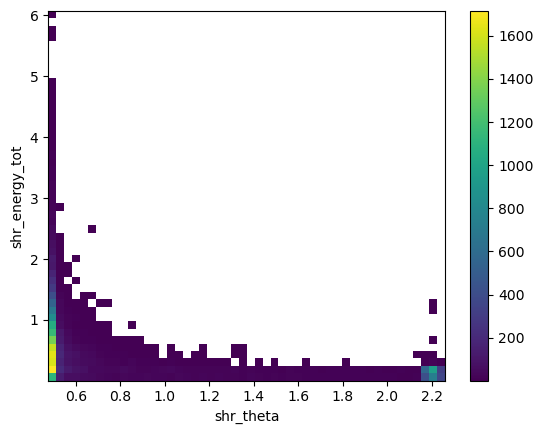

ROOT


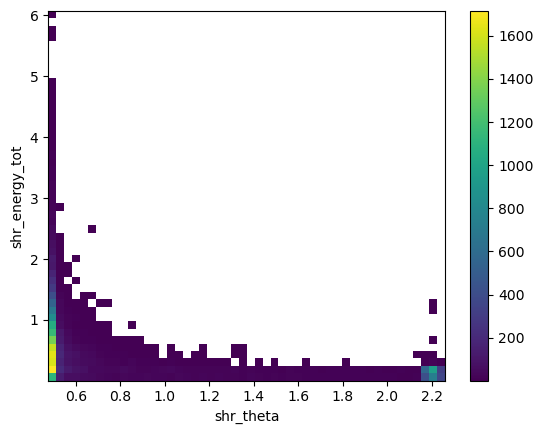

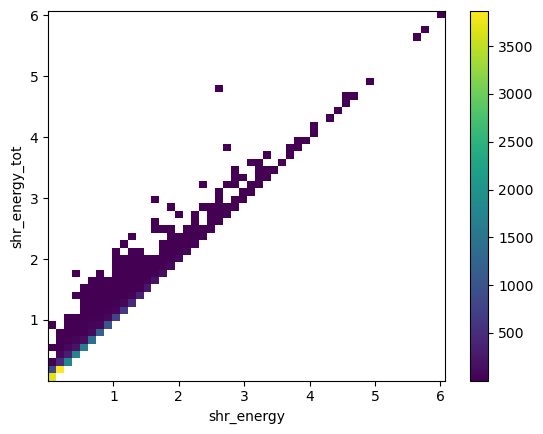

100 MeV: selection_eff =  0.4935566732143243


In [64]:
run = 'Run3'
if run == 'Run1': horn_config = 'fhc'
if run == 'Run3': horn_config = 'rhc'
shrs = ['1shr' ,'2shr']
decay_pos = ['KDIF','KDAR']

mass_points  = ['100'] #,'150','200', '125','130','135','140','145', '150', '200']



for mass_scalar in mass_points:
    train_file = f"sfn_numi_{horn_config}_generic_{mass_scalar}_ppfx_CV_train.root"
    with uproot.open(ROOT_DIR+"Final_v51_FHC/"+train_file) as train_data:
        print(train_file)
        pkl_shr_energy = []
        pkl_shr_angle = []
        indices = []
        
        keys = train_data.keys()
        train_data = train_data[keys[0]]
        keys = train_data.keys()
        
        
        for pos in decay_pos:
            for shr in shrs:
                pkl_filepath = ROOT_DIR+'BDT_inputs_pkl/AllVar_Selected_{}_NuMI_Signal_{}_{}_{}_PPFX_pred_NEW.pkl'.format(run,pos,mass_scalar,shr)

                pkl_data = pd.read_pickle(pkl_filepath)
                
                pkl_shr_energy += pkl_data['shr_energy_tot_ls'].values.tolist()
                # test_shr_energy += pkl_data.query('is_trained==0')['shr_energy_tot_ls'].values.tolist()
                
                pkl_shr_angle += pkl_data['theta_ls'].values.tolist()
                
                indices.append(match_RSE_indices(pkl_data, train_data, columns=[1,2,3]))

        index_arr = []
        for x in indices:
            overlap_arr = []
            index_arr += x
            
            # for y in indices:
            #     overlap_arr.append(collections.Counter(x) == collections.Counter(y))


        train_data  = train_data[keys[0]]
        keys = train_data.keys()

        pkl_shr_energy = np.array(pkl_shr_energy).ravel()

        pkl_shr_angle = np.array(pkl_shr_angle).ravel()
        
        shr_energy = train_data['shr_energy'].array()[index_arr].to_numpy()
        shr_energy_tot = train_data['shr_energy_tot'].array()[index_arr].to_numpy()
        shr_angle = train_data['theta'].array()[index_arr].to_numpy()
        
        
        all_shr_energy = train_data['shr_energy_tot'].array().to_numpy()

        print("PKL")
        plt.hist2d(pkl_shr_angle, pkl_shr_energy, bins=(50,50), cmin=1, )
        plt.xlabel('shr_theta')
        plt.ylabel('shr_energy_tot')
        plt.colorbar()
        plt.show()

        print("ROOT")
        plt.hist2d(shr_angle, shr_energy_tot, bins=(50,50), cmin=1, )
        plt.xlabel('shr_theta')
        plt.ylabel('shr_energy_tot')
        plt.colorbar()
        plt.show()

        plt.hist2d(shr_energy, shr_energy_tot, bins=(50,50), cmin=1, )
        plt.xlabel('shr_energy')
        plt.ylabel('shr_energy_tot')
        plt.colorbar()
        plt.show()

        # print(np.shape(pkl_shr_energy), np.shape(shr_energy))
        # print(np.shape(all_shr_energy))

    print("{} MeV: selection_eff = ".format(mass_scalar), len(pkl_shr_energy)/len(all_shr_energy))


100 MeV: selection_eff =  0.4935566732143243

125 MeV: selection_eff =  0.4930044104923291

130 MeV: selection_eff =  0.49629134368274797

135 MeV: selection_eff =  0.4931202553485162

140 MeV: selection_eff =  0.49561654885478357

145 MeV: selection_eff =  0.48783728755438394

150 MeV: selection_eff =  0.4933422679520989

200 MeV: selection_eff =  0.4854800431499461

In [72]:
keys

['selected',
 'run',
 'sub',
 'evt',
 'trk_id',
 'shr_id',
 'trk2_id',
 'shr2_id',
 'shr_energy_tot',
 'shr_energy',
 'shr_energy_tot_cali',
 'shr_energy_cali',
 'shr_theta',
 'shr_phi',
 'shr_pca_0',
 'shr_pca_1',
 'shr_pca_2',
 'shr_px',
 'shr_py',
 'shr_pz',
 'shr_openangle',
 'shr_tkfit_start_x',
 'shr_tkfit_start_y',
 'shr_tkfit_start_z',
 'shr_tkfit_theta',
 'shr_tkfit_phi',
 'shr_start_x',
 'shr_start_y',
 'shr_start_z',
 'shr_dedx_Y',
 'shr_dedx_V',
 'shr_dedx_U',
 'shr_dedx_Y_cali',
 'shr_dedx_V_cali',
 'shr_dedx_U_cali',
 'shr_tkfit_dedx_Y',
 'shr_tkfit_dedx_V',
 'shr_tkfit_dedx_U',
 'shr_tkfit_dedx_max',
 'shr_tkfit_nhits_Y',
 'shr_tkfit_nhits_V',
 'shr_tkfit_nhits_U',
 'shr_llrpid_dedx_Y',
 'shr_llrpid_dedx_V',
 'shr_llrpid_dedx_U',
 'shr_llrpid_dedx',
 'shr_tkfit_dedx_Y_alt',
 'shr_tkfit_dedx_V_alt',
 'shr_tkfit_dedx_U_alt',
 'shr_tkfit_nhits_Y_alt',
 'shr_tkfit_nhits_V_alt',
 'shr_tkfit_nhits_U_alt',
 'trkfit',
 'shr_tkfit_npoints',
 'shr_tkfit_npointsvalid',
 'shr_trkfit